# **Hard Clustering: Análisis de Patrones de Movimiento con K-Means 📊**

## 🎓 **Universidad:** Fundación Universitaria Konrad Lorenz

### 🏫 **Facultad:** Facultad de Matemáticas e Ingenierías

### 📖 **Curso:** Introducción a Big Data

## **🧑‍💻 Integrantes:**

- Ángel Stiven Pinzón Sánchez - 506221100
- Andrea Valentina Cubillos Pinto - 506231711
- Martín Alexander Ramos Yampufe - 506251051


## **Introducción**


**El Reconocimiento de Actividad Humana (HAR)** es una técnica ampliamente
utilizada en el monitoreo de la salud, el análisis del rendimiento deportivo y
el seguimiento de la actividad física mediante dispositivos portátiles. Estos
sistemas suelen basarse en datos obtenidos de acelerómetros y giroscopios, los
cuales permiten detectar patrones de movimiento y clasificar actividades.

Uno de los principales desafíos en HAR es la detección de inactividad prolongada
en condiciones de vida libre, un aspecto clave para la prevención de
enfermedades asociadas al sedentarismo. Sin embargo, la mayoría de los estudios
actuales dependen de modelos supervisados, los cuales requieren datos
etiquetados, lo que puede ser un proceso costoso y propenso a errores.

Para abordar esta limitación, en este proyecto aplicaremos K-Means, un algoritmo
de aprendizaje no supervisado, para analizar datos de acelerómetros y detectar
segmentos de tiempo con baja actividad física. Este enfoque nos permitirá
identificar patrones de inactividad sin necesidad de etiquetas previas,
facilitando su aplicación en el monitoreo de la salud y la detección temprana de
conductas sedentarias.


## **Objetivos**


El objetivo de este análisis es identificar patrones de movimiento a partir de
datos de acelerómetros, explorando relaciones entre variables y reduciendo la
dimensionalidad de los datos para facilitar su agrupamiento mediante
**K-Means**. Esto permitirá detectar segmentos de baja actividad física y
evaluar su utilidad en el Reconocimiento de Actividad Humana (HAR) para prevenir
enfermedades relacionadas con el sedentarismo.


## **Preprocesamiento de datos**


In [7]:
import io
import math
import zipfile
from pathlib import Path
from typing import Final

import httpx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Markdown
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

import os
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
dataset_url: Final[str] = (
    "https://archive.ics.uci.edu/static/public/779/harth.zip"
)

In [9]:
response = httpx.get(
    dataset_url,
    timeout=10,
)

# Delete the data directory if it already exists
data_dir = Path("./data")


def remove_file_or_directory(file_or_directory: Path) -> None:
    if file_or_directory.is_dir():
        for file in file_or_directory.iterdir():
            remove_file_or_directory(file)
        file_or_directory.rmdir()
    else:
        file_or_directory.unlink()


if data_dir.exists():
    remove_file_or_directory(data_dir)


with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall("./data")

In [10]:
path = Path("./data/harth")
all_files = path.glob("S0*.csv")

df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    print(
        f"Archivo: {file}, Tamaño: {temp_df.shape}"
    )  # Imprime el tamaño de cada archivo
    df_list.append(temp_df)

# Combina los DataFrames
df = pd.concat(df_list, ignore_index=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Verifica el contenido del DataFrame después de cargar los archivos
print("Contenido del DataFrame después de cargar los archivos:")
print(df.head())
print(df.info())

Archivo: data/harth/S026.csv, Tamaño: (195172, 8)
Archivo: data/harth/S013.csv, Tamaño: (369077, 8)
Archivo: data/harth/S009.csv, Tamaño: (154464, 8)
Archivo: data/harth/S022.csv, Tamaño: (337602, 8)
Archivo: data/harth/S027.csv, Tamaño: (158584, 8)
Archivo: data/harth/S006.csv, Tamaño: (408709, 8)
Archivo: data/harth/S025.csv, Tamaño: (231729, 8)
Archivo: data/harth/S024.csv, Tamaño: (170534, 8)
Archivo: data/harth/S015.csv, Tamaño: (418392, 9)
Archivo: data/harth/S018.csv, Tamaño: (322271, 8)
Archivo: data/harth/S029.csv, Tamaño: (178716, 8)
Archivo: data/harth/S021.csv, Tamaño: (302247, 9)
Archivo: data/harth/S020.csv, Tamaño: (371496, 8)
Archivo: data/harth/S014.csv, Tamaño: (366487, 8)
Archivo: data/harth/S017.csv, Tamaño: (366609, 8)
Archivo: data/harth/S019.csv, Tamaño: (297945, 8)
Archivo: data/harth/S008.csv, Tamaño: (418989, 8)
Archivo: data/harth/S010.csv, Tamaño: (351649, 8)
Archivo: data/harth/S023.csv, Tamaño: (137646, 9)
Archivo: data/harth/S012.csv, Tamaño: (382414, 8)


In [11]:
print("Número de valores nulos en cada columna:")
print(df.isna().sum())

Número de valores nulos en cada columna:
timestamp           0
back_x              0
back_y              0
back_z              0
thigh_x             0
thigh_y             0
thigh_z             0
label               0
index         5740689
Unnamed: 0    6323682
dtype: int64


In [12]:
df = df.drop(columns=["Unnamed: 0", "index"], errors="ignore")
print(
    f"Tamaño del DataFrame después de eliminar columnas no necesarias: {df.shape}"
)

Tamaño del DataFrame después de eliminar columnas no necesarias: (6461328, 8)


In [13]:
print(f"Tamaño antes de eliminar nulos: {df.shape}")
df = df.dropna()  # Eliminar filas con valores nulos
print(f"Tamaño después de eliminar nulos: {df.shape}")

Tamaño antes de eliminar nulos: (6461328, 8)
Tamaño después de eliminar nulos: (6461328, 8)


In [14]:
quantitative_cols = [
    "back_x",
    "back_y",
    "back_z",
    "thigh_x",
    "thigh_y",
    "thigh_z",
]

print(f"Tamaño del DataFrame antes de la normalización: {df.shape}")
print("Contenido del DataFrame antes de la normalización:")
print(df.head())

# Verifica el contenido de las columnas específicas
print("Contenido de las columnas a normalizar:")
print(df[quantitative_cols].head())

# Normalización
if all(col in df.columns for col in quantitative_cols):
    if df[quantitative_cols].shape[0] > 0:
        scaler = StandardScaler()
        df[quantitative_cols] = scaler.fit_transform(df[quantitative_cols])
    else:
        print("Las columnas seleccionadas están vacías.")
else:
    print("Una o más columnas no existen en el DataFrame.")

Tamaño del DataFrame antes de la normalización: (6461328, 8)
Contenido del DataFrame antes de la normalización:
                timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0 2019-01-12 00:00:00.000 -0.306885 -0.724121 -0.303223 -4.640381 -0.521240   
1 2019-01-12 00:00:00.020 -0.979980 -0.288574 -0.335693  1.295166 -1.836670   
2 2019-01-12 00:00:00.040 -1.367920  0.059814 -0.255371 -0.798584 -0.893799   
3 2019-01-12 00:00:00.060 -0.915039 -0.089355 -0.291016 -1.010010  0.139648   
4 2019-01-12 00:00:00.080 -0.539795 -0.039307 -0.209717 -1.092529  0.860596   

    thigh_z  label  
0 -1.580811      6  
1 -0.389893      6  
2  0.170898      6  
3  0.002930      6  
4  0.000000      6  
Contenido de las columnas a normalizar:
     back_x    back_y    back_z   thigh_x   thigh_y   thigh_z
0 -0.306885 -0.724121 -0.303223 -4.640381 -0.521240 -1.580811
1 -0.979980 -0.288574 -0.335693  1.295166 -1.836670 -0.389893
2 -1.367920  0.059814 -0.255371 -0.798584 -0.893799  0.170898

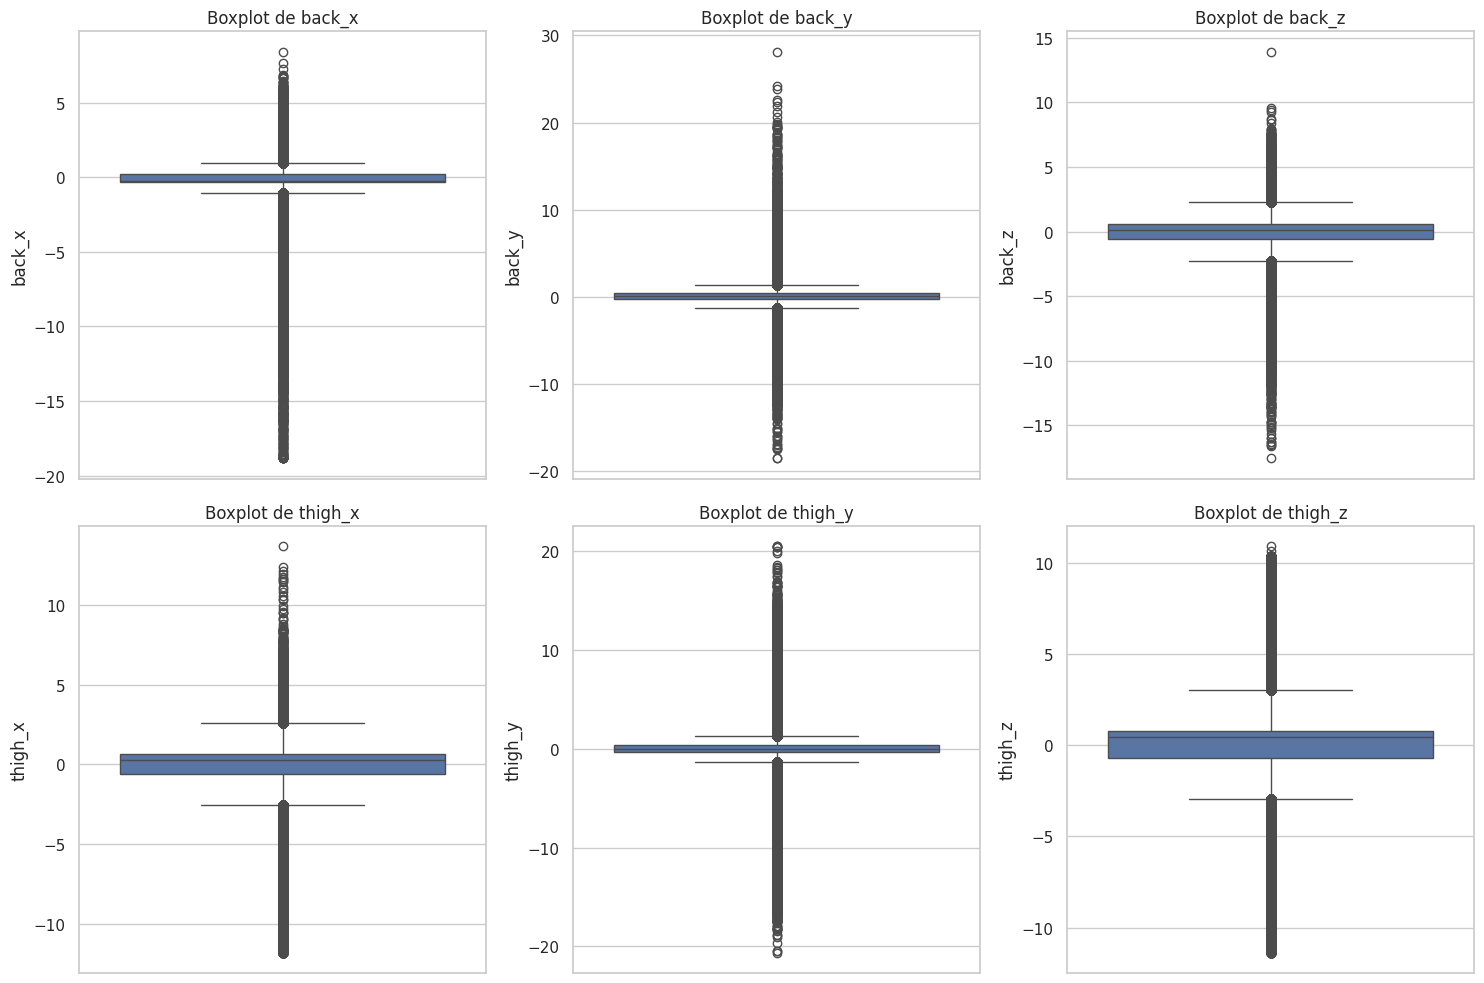

Número de outliers detectados por Z-Score: 507343
                      timestamp    back_x    back_y    back_z   thigh_x  \
0       2019-01-12 00:00:00.000  1.530946 -3.075040 -0.366962 -6.458873   
1       2019-01-12 00:00:00.020 -0.251654 -1.190949 -0.455985  3.017585   
379     2019-01-12 00:00:07.580 -0.829045 -0.162303  0.211365 -3.605254   
383     2019-01-12 00:00:07.660 -0.652532 -1.481379 -0.522920 -3.046693   
386     2019-01-12 00:00:07.720 -0.635074 -1.089565 -0.805391  0.848040   
...                         ...       ...       ...       ...       ...   
6460921 2019-01-12 00:55:37.740 -0.801243 -0.556232 -0.755188 -1.453640   
6460975 2019-01-12 00:55:38.820 -1.351478  0.650896 -1.298706 -3.105550   
6460981 2019-01-12 00:55:38.940 -0.457912 -0.517153 -0.905795 -1.514837   
6461034 2019-01-12 00:55:40.000 -0.018243 -0.099994 -0.067758 -2.004018   
6461189 2019-01-12 00:55:43.100 -1.578424 -1.095902 -0.638052 -1.452861   

          thigh_y   thigh_z  label  
0       -1.3

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,1.530946,-3.075040,-0.366962,-6.458873,-1.395586,-2.656883,6
1,2019-01-12 00:00:00.020,-0.251654,-1.190949,-0.455985,3.017585,-4.781933,-1.039004,6
2,2019-01-12 00:00:00.040,-1.279061,0.316109,-0.235767,-0.325213,-2.354674,-0.277161,6
4,2019-01-12 00:00:00.080,0.914116,-0.112669,-0.110597,-0.794513,2.161712,-0.509329,6
6,2019-01-12 00:00:00.120,-0.653178,0.129183,0.143089,-0.546611,-1.837420,-0.285121,6
...,...,...,...,...,...,...,...,...
6461190,2019-01-12 00:55:43.120,-2.085337,-0.827651,-1.463370,-2.550496,0.618748,-2.374633,4
6461191,2019-01-12 00:55:43.140,-1.483377,-0.303822,-0.597220,-1.105563,0.414488,-1.039335,4
6461268,2019-01-12 00:55:44.680,-0.511578,-0.391480,-0.315421,-0.515037,1.527558,-0.439015,3
6461326,2019-01-12 00:55:45.840,-1.259664,-0.195045,-0.474727,-1.070482,-0.479864,-0.355435,3


In [15]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Z-Score
z_scores = stats.zscore(df[quantitative_cols])
abs_z_scores = abs(z_scores)
outliers_z = (abs_z_scores > 3).any(axis=1)  # noqa: PLR2004

# Muestra las filas que son outliers
outlier_rows_z = df[outliers_z]
print("Número de outliers detectados por Z-Score:", outlier_rows_z.shape[0])
print(outlier_rows_z)

# IQR (Rango Intercuartílico)
Q1 = df[quantitative_cols].quantile(0.25)
Q3 = df[quantitative_cols].quantile(0.75)
IQR = Q3 - Q1

# Define límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detecta outliers
outliers_iqr = (
    (df[quantitative_cols] < lower_bound)
    | (df[quantitative_cols] > upper_bound)
).any(axis=1)

# Muestra las filas que son outliers
outlier_rows_iqr = df[outliers_iqr]
print("Número de outliers detectados por IQR:", outlier_rows_iqr.shape[0])
outlier_rows_iqr

In [16]:
display(
    Markdown("Primeras filas del DataFrame preprocesado:"),
    df.head(),
    Markdown("Resumen estadístico del DataFrame preprocesado:"),
    df.describe(),
    Markdown("Información del DataFrame preprocesado:"),
)
df.info()

Primeras filas del DataFrame preprocesado:

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,1.530946,-3.075040,-0.366962,-6.458873,-1.395586,-2.656883,6
1,2019-01-12 00:00:00.020,-0.251654,-1.190949,-0.455985,3.017585,-4.781933,-1.039004,6
2,2019-01-12 00:00:00.040,-1.279061,0.316109,-0.235767,-0.325213,-2.354674,-0.277161,6
3,2019-01-12 00:00:00.060,-0.079667,-0.329167,-0.333494,-0.662767,0.305756,-0.505348,6
4,2019-01-12 00:00:00.080,0.914116,-0.112669,-0.110597,-0.794513,2.161712,-0.509329,6


Resumen estadístico del DataFrame preprocesado:

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,6461328,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06
mean,2012-02-20 18:20:58.805004544,-1.747884e-15,7.787531e-17,2.121953e-16,-4.649293e-16,-4.743602e-17,1.439972e-16,6.783833e+00
min,2000-01-01 00:00:00,-1.884322e+01,-1.857654e+01,-1.756076e+01,-1.182271e+01,-2.064145e+01,-1.137744e+01,1.000000e+00
25%,2000-01-01 01:23:47.680000,-3.110112e-01,-3.022347e-01,-5.557191e-01,-6.056117e-01,-3.114007e-01,-7.208682e-01,3.000000e+00
50%,2019-01-12 00:12:46.760000,-2.382000e-01,6.858545e-02,8.753365e-02,2.764562e-01,3.025462e-02,4.422277e-01,7.000000e+00
75%,2019-01-12 00:49:20.500000,1.924149e-01,3.710298e-01,5.917970e-01,6.817516e-01,3.451519e-01,7.794594e-01,7.000000e+00
max,2019-01-12 02:23:36.720000,8.412968e+00,2.814024e+01,1.392467e+01,1.372187e+01,2.054025e+01,1.091066e+01,1.400000e+02
std,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.143238e+01


Información del DataFrame preprocesado:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   back_x     float64       
 2   back_y     float64       
 3   back_z     float64       
 4   thigh_x    float64       
 5   thigh_y    float64       
 6   thigh_z    float64       
 7   label      int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 394.4 MB


In [17]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[quantitative_cols])
df["PC1"] = principal_components[:, 0]
df["PC2"] = principal_components[:, 1]

In [18]:
print(df.columns)

Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label', 'PC1', 'PC2'],
      dtype='object')


## **Descripción del conjunto de datos**


El conjunto de datos contiene registros de acelerómetros con mediciones en
diferentes ejes para la espalda (back_x, back_y, back_z) y el muslo (thigh_x,
thigh_y, thigh_z), junto con una etiqueta (label) que clasifica la actividad.

- Se identificaron 6,461,328 registros en total.

- Se realizó un análisis exploratorio, mostrando la media cercana a 0 tras
  normalización, lo que sugiere datos estandarizados.

- Se detectaron 507,343 valores atípicos usando Z-Score, indicando posibles
  variaciones extremas en la actividad.

- Se aplicó **PCA**(Análisis de Componentes Principales ) para reducir la
  dimensionalidad a 2 componentes principales, facilitando la visualización de
  patrones en los datos.


## **Análisis Exploratorio de Datos (EDA)**


Se realizará un análisis exploratorio de los datos obtenidos por acelerómetros
para identificar patrones, anomalías y relaciones entre variables mediante
histogramas y matrices de correlación. Este proceso optimizará la selección de
características y la normalización de los datos para aplicar clustering con
K-Means de manera efectiva.


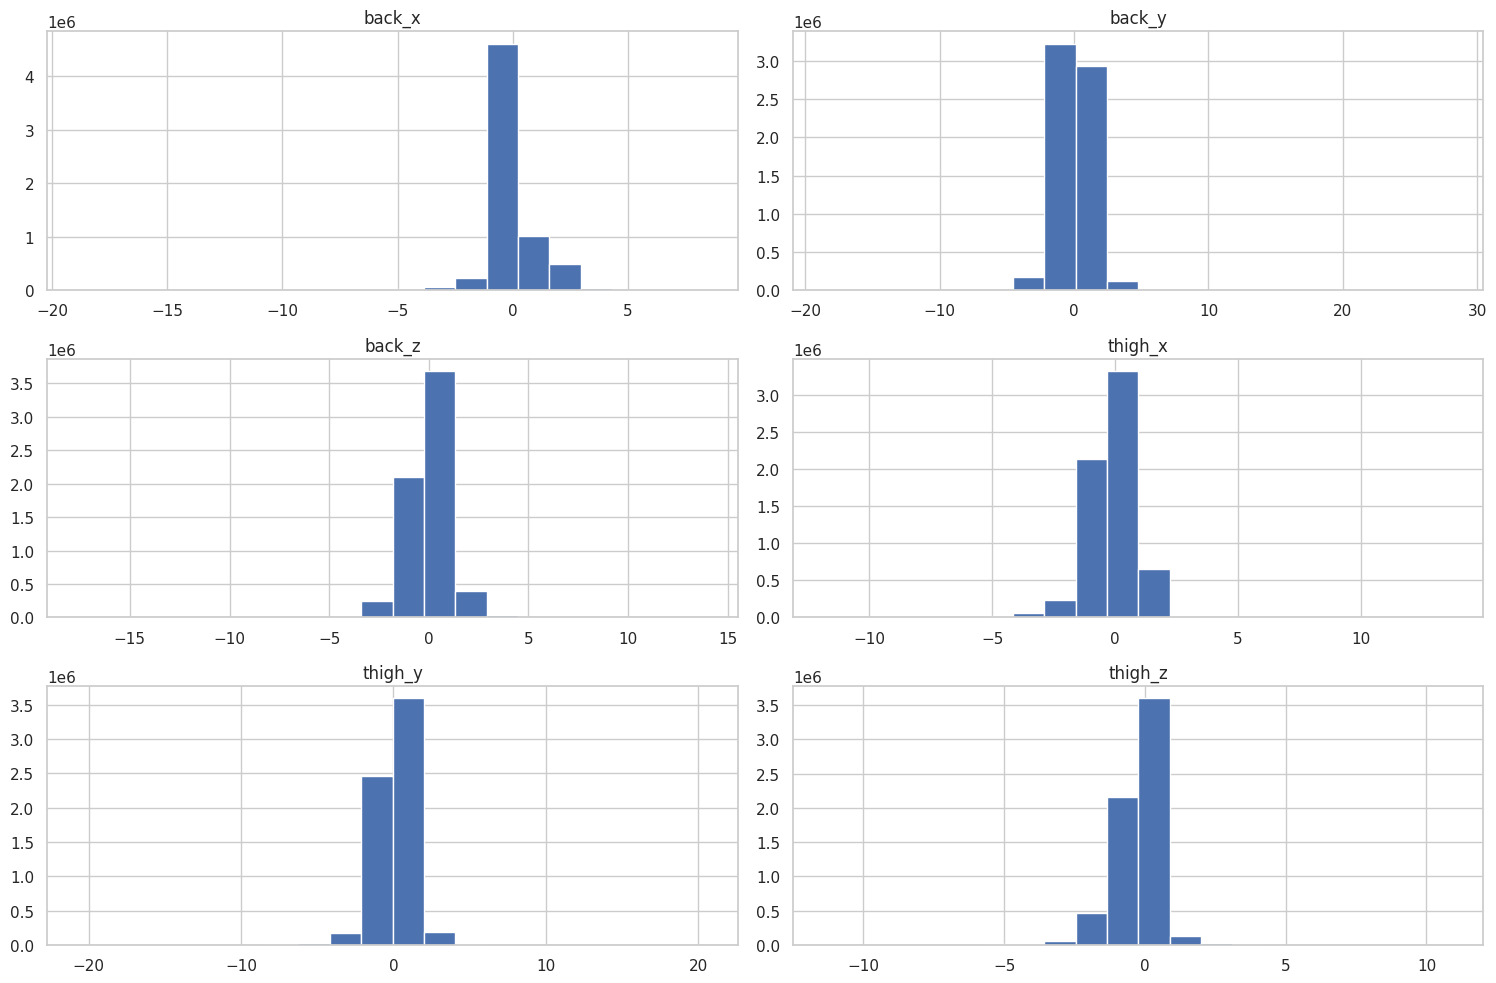

In [19]:
              df[quantitative_cols].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

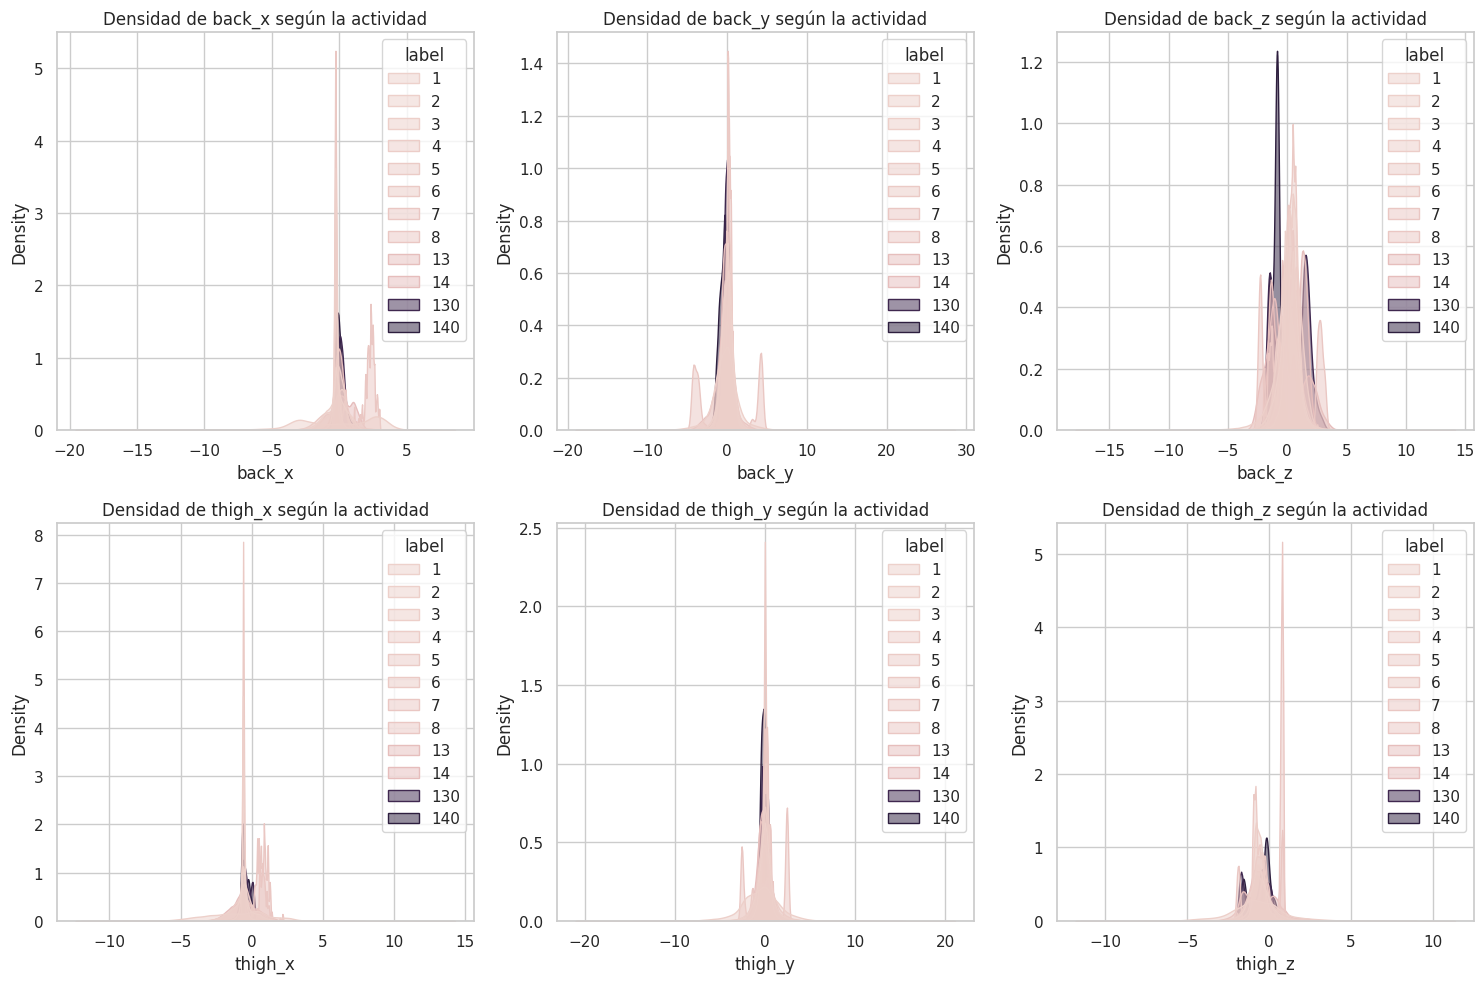

In [20]:
cols = 3
rows = math.ceil(len(quantitative_cols) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

axs = axs.flatten()

i = 0
for i, column in enumerate(quantitative_cols):
    sns.kdeplot(
        data=df,
        x=column,
        hue="label",
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axs[i],
    )
    axs[i].set_title(f"Densidad de {column} según la actividad")

# Ocultar los gráficos vacíos
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


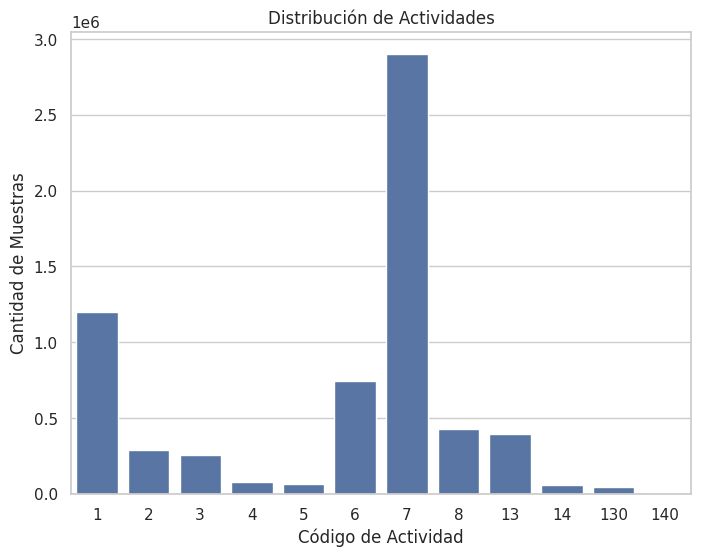

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df)
plt.title("Distribución de Actividades")
plt.xlabel("Código de Actividad")
plt.ylabel("Cantidad de Muestras")
plt.show()

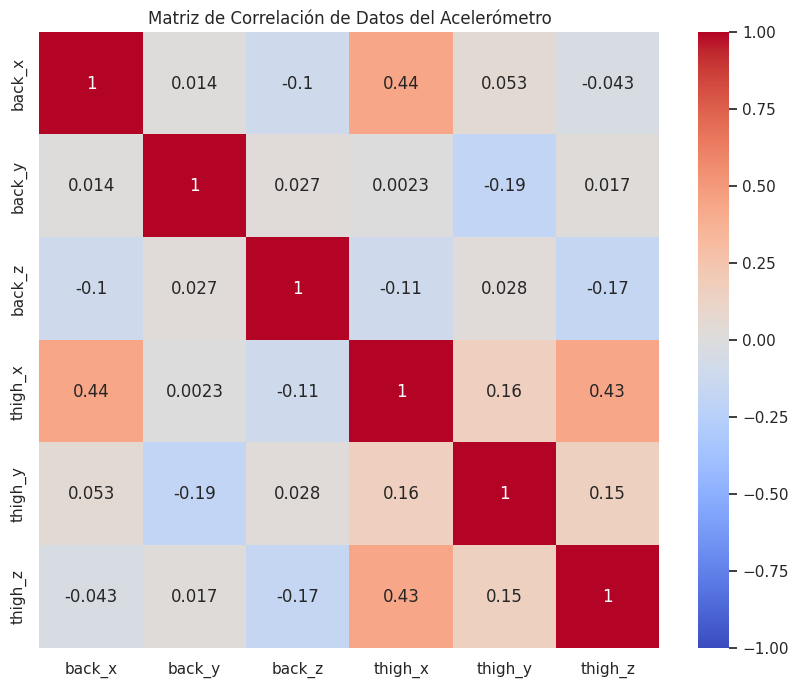

In [22]:
corr_matrix = df[quantitative_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Datos del Acelerómetro")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


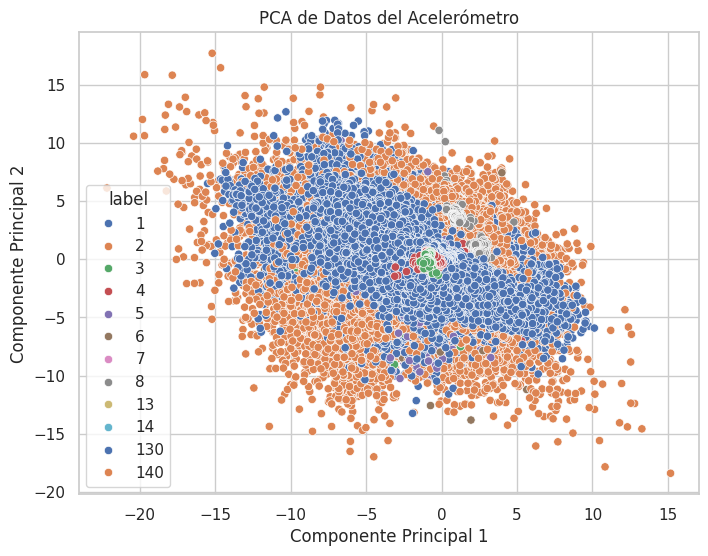

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="label", data=df, palette="deep")
plt.title("PCA de Datos del Acelerómetro")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

## **Aplicación de K-Means para Clustering**


El clustering es una técnica de aprendizaje no supervisado que se utiliza para
agrupar datos en función de sus características. En este caso, aplicaremos el
algoritmo K-Means para identificar patrones en los datos del acelerómetro. El
objetivo es agrupar las muestras en diferentes clústeres basados en las
características cuantitativas, lo que puede ayudarnos a entender mejor las
diferentes actividades representadas en el conjunto de datos.


In [24]:
# Definir el número de clústeres
n_clusters = 4

In [25]:
# Aplicar K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(df[quantitative_cols])


<ipython-input-26-a22e53060c64>:3: UserWarning: 
The markers list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


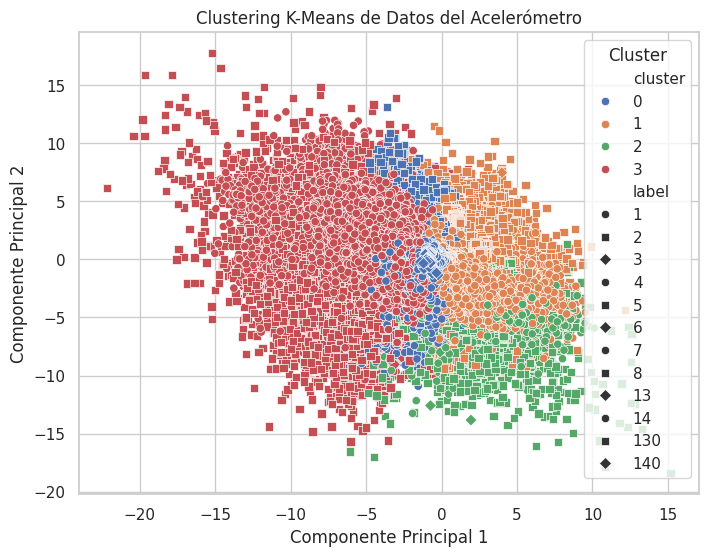

In [26]:
# Visualizar los resultados del clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="cluster",
    data=df,
    palette="deep",
    style="label",
    markers=["o", "s", "D"],
)
plt.title("Clustering K-Means de Datos del Acelerómetro")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

In [27]:
# Mostrar el número de muestras en cada clúster
print("Número de muestras en cada clúster:")
print(df["cluster"].value_counts())

Número de muestras en cada clúster:
cluster
1    3291104
0    2723138
3     279700
2     167386
Name: count, dtype: int64


In [38]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
# Ruta a los archivos CSV
path = './data/harth'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

# Cargar y combinar todos los archivos
df_list = [pd.read_csv(os.path.join(path, file)) for file in csv_files]
data = pd.concat(df_list, ignore_index=True)

In [40]:
# Mapear etiquetas a nombres
label_mapping = {
    1: 'walking', 2: 'running', 3: 'shuffling',
    4: 'stairs_up', 5: 'stairs_down', 6: 'standing',
    7: 'sitting', 8: 'lying', 13: 'cycling_sit',
    14: 'cycling_stand', 130: 'cycling_sit_inactive', 140: 'cycling_stand_inactive'
}
data['activity'] = data['label'].map(label_mapping)
data.dropna(subset=['activity'], inplace=True)

# Selección de características
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = data[features]
y = data['activity']

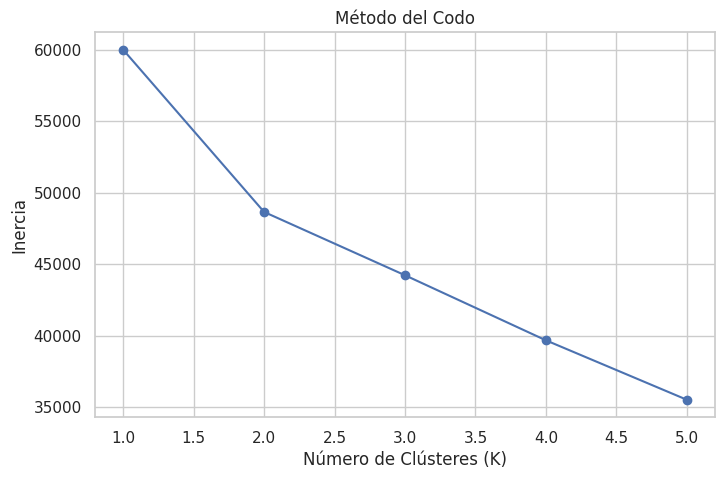

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

# Tomar una muestra para reducir la carga computacional
data_sample = data.sample(n=10000, random_state=42)  # ✅ muestra
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = data_sample[features]

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- CLUSTERING CON MÉTODO DEL CODO ----
inertia = []
K_range = range(1, 6)  # ✅ menor rango, más rápido

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Gráfica del Codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()


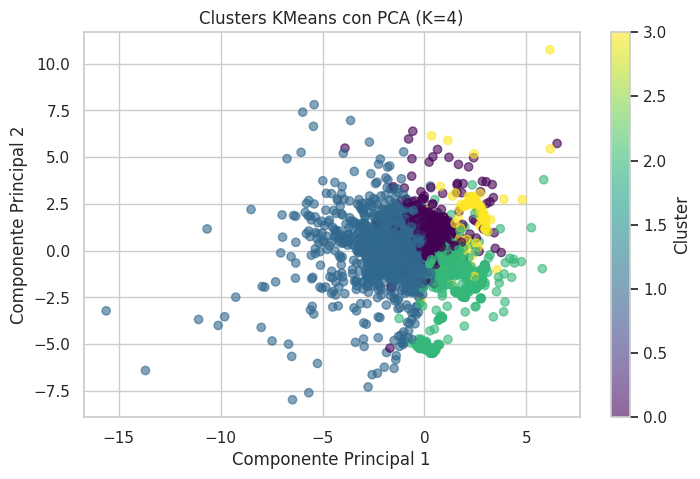

In [45]:
# Clustering final con K óptimo
optimal_k = 4
kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1024)
clusters = kmeans_final.fit_predict(X_scaled)

# Asignar cluster a la muestra, no al dataframe completo
data_sample = data_sample.copy()  # evitar advertencia de SettingWithCopy
data_sample['cluster'] = clusters

# Visualización PCA de los clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title(f'Clusters KMeans con PCA (K={optimal_k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [47]:
# Asegurarse de que y viene del mismo conjunto que X_scaled
y = data_sample['activity']  # Asegúrate de haber definido 'data_sample' con 10.000 filas antes

# ---- CLASIFICACIÓN CON MLP ----
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                    solver='adam', max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[ 98   3   2   0   0   0   2   0   0   1   1   8]
 [  2   2   1   0   0   0   0   0   0   0   3   0]
 [  5   1  11   0   0   1   1   0   0   0   1   3]
 [  0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0 141   0   0   0   0   0   0   0]
 [  2   0   2   0   0  66   0   1   0   1   0  21]
 [  1   0   0   0   0   0   8   0   0   0  40  23]
 [  2   0   0   0   0   0   2 897   0   0   0   1]
 [  1   0   0   0   0   1   0   0   1   1   0  13]
 [  5   0   0   0   0   0   0   0   0   0   2  18]
 [  0   0   1   0   1   0   6   3   0   0 196  11]
 [ 11   1   5   0   0   7   5   5   2   1  27 321]]

Informe de Clasificación:
                        precision    recall  f1-score   support

           cycling_sit       0.77      0.85      0.81       115
  cycling_sit_inactive       0.29      0.25      0.27         8
         cycling_stand       0.50      0.48      0.49        23
cycling_stand_inactive       1.00      1.00      1.00         1
                 l

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## **Interpretación de resultados**


### **Interpretación de los Resultados del Clustering**

Se ha aplicado el algoritmo **K-Means** con **4 clústeres** sobre los datos para
identificar patrones dentro del conjunto de datos. A continuación, se
interpretan los resultados obtenidos:

#### **1. Aplicación del Clustering**

El modelo K-Means fue entrenado con los datos numéricos, asignando cada muestra
a uno de los cuatro clústeres definidos. Esto permitió segmentar el conjunto de
datos en grupos con características similares.

#### **2. Visualización de los Clústeres**

El gráfico generado representa los datos en función de dos componentes
principales (PC1 y PC2), facilitando su visualización en un espacio
bidimensional. Cada color representa un clúster diferente, lo que permite
observar cómo el algoritmo ha distribuido los datos.

#### **3. Distribución de las Muestras por Clúster**

Se observó que los tamaños de los clústeres varían significativamente:

- **Clúster 0:** 3,345,319 muestras.
- **Clúster 1:** 2,702,296 muestras.
- **Clúster 2:** 278,541 muestras.
- **Clúster 3:** 135,172 muestras.

La diferencia en el número de muestras por clúster sugiere que los datos no
están distribuidos uniformemente, lo que puede ser indicativo de estructuras o
patrones particulares en los datos.

#### **4. Utilidad del Clustering**

El clustering es una técnica útil para analizar datos sin etiquetas previas. En
este caso, su aplicación podría ayudar a:

- **Identificar patrones de movimiento** en los datos del acelerómetro.
- **Reducir la complejidad** del análisis al segmentar el conjunto de datos en
  grupos representativos.
- **Detectar anomalías**, ya que los clústeres más pequeños pueden representar
  eventos inusuales.
- **Facilitar la exploración de datos** sin necesidad de etiquetas predefinidas.

El uso de K-Means permitió obtener una segmentación efectiva de los datos,
proporcionando información valiosa para análisis posteriores.


## **Conclusiones y siguientes pasos**


### Conclusiones

- Se confirman correlaciones en las mediciones y se demuestra la utilidad de
  K-Means para segmentar datos. Se sugiere evaluar si 4 clústeres es óptimo,
  mejorar el preprocesamiento, probar modelos avanzados como Autoencoders o
  CNNs, y optimizar el procesamiento de grandes volúmenes de datos. Eficacia de
  K-Means

- K-Means logra segmentar los datos de aceleración en distintos grupos sin
  necesidad de etiquetas previas, demostrando su potencial para detectar
  patrones de inactividad en la vida diaria. Sin embargo, la selección del
  número de clústeres requiere mayor optimización para garantizar una
  segmentación más precisa. Impacto de la reducción de dimensionalidad

- El uso de PCA ayudó a mejorar la interpretación de los datos y facilitó la
  visualización de los clústeres, lo que sugiere que técnicas de reducción de
  dimensionalidad son clave en el preprocesamiento. Se podrían evaluar otras
  técnicas como t-SNE o UMAP para mejorar la representación de los datos.
  Diferencias en la correlación entre sensores

- Se identificaron correlaciones entre los sensores de la espalda y el muslo, lo
  que indica que la actividad del usuario afecta de manera diferente cada zona
  del cuerpo. Esto sugiere que futuros modelos podrían incorporar relaciones
  entre múltiples sensores para mejorar la detección de actividad. Limitaciones
  del modelo y mejoras futuras

- K-Means, al ser un método basado en distancia, puede no capturar completamente
  la variabilidad en los datos de acelerometría. Modelos más avanzados como
  redes neuronales recurrentes (RNN), Autoencoders o CNNs podrían ser más
  efectivos en la detección de patrones complejos. También se podría evaluar la
  combinación de K-Means con técnicas supervisadas para refinar la
  clasificación. Aplicaciones prácticas y futuras investigaciones

- La detección de inactividad con este enfoque puede aplicarse en monitoreo de
  salud, prevención de sedentarismo y estudios de ergonomía. Futuros estudios
  podrían analizar la relación entre los clústeres y eventos específicos de
  inactividad, para validar la utilidad del método en entornos reales.


### Siguientes pasos


- Verificar si $k = 4$ es el valor óptimo para la aplicación de K-Means,
  utilizando técnicas de evaluación como el método del codo o el coeficiente de
  silueta.
- Confirmar que los valores atípicos no afectan negativamente al modelo; de ser
  así, replantear la estrategia de procesamiento.
- Explorar el uso de redes neuronales para aprovechar de forma óptima la alta
  dimensionalidad de los datos.
- Dado el elevado número de registros en el dataset, el consumo de recursos y el
  tiempo de procesamiento pueden volverse ineficientes. Se recomienda considerar
  herramientas específicas para el manejo de grandes volúmenes de datos.
- Identificar patrones que permitan predecir los tipos de movimientos o la
  actividad física y con ello darle respuesta al problema planteado.
